### Introduction

This notebook creates a Sionna Scene (https://nvlabs.github.io/sionna/api/rt.html#scene) using openstreetmap. This can be used as an alternative to exporting scene from Blender (https://www.youtube.com/watch?v=7xHLDxUaQ7c).

In [1]:
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import pyproj
import shapely
from shapely.geometry import shape
from shapely.ops import transform
import math
import pyvista as pv
import numpy as np
import osmnx as ox
from shapely.geometry import LineString
import os
from pyproj import Transformer
import open3d as o3d
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom
import mitsuba as mi
mi.set_variant("llvm_ad_rgb")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Set the center position lat and lon as a starting point. Use any string of your choice for LOCATION_STR
# center_lat = 14.557097311312177
# center_lon = 121.02000072883868
# LOCATION_STR = "PHILLIPINES"

center_lat = 40.754820
center_lon = -73.984146
LOCATION_STR = "NYC"

def get_utm_epsg(lat, lon):
    """Calculates the WGS84 UTM EPSG code for a given latitude and longitude."""
    zone_number = math.floor((lon + 180) / 6) + 1
    
    if lat >= 0:
        # Hemisferio Norte: EPSG 326xx
        return f"epsg:326{int(zone_number)}"
    else:
        # Hemisferio Sur: EPSG 327xx
        return f"epsg:327{int(zone_number)}"
    
target_epsg = get_utm_epsg(center_lat, center_lon)
print(f"Target EPSG: {target_epsg}")

Target EPSG: epsg:32618


#### Initialize Sionna Scene XML object and add defaults

In [3]:
# Set up default values for resolution
spp_default = 4096
resx_default = 1920
resy_default = 1080

# Define camera settings
camera_settings = {
    "rotation": (0, 0, -90),  # Assuming Z-up orientation
    "fov": 42.854885
}

# Define material colors. This is RGB 0-1 formar https://rgbcolorpicker.com/0-1
material_colors = {
    "mat-itu_concrete": (0.5, 0.5, 0.5), # gray
    # "mat-itu_glass": (0.552941, 0.627451, 0.674510),
    "mat-itu_brick": (1.0, 0.0, 0.0), # pure red
    # "mat-itu_marble": (0.701101, 0.644479, 0.485150),
    # "mat-itu_metal": (0.219526, 0.219526, 0.254152),
    # "mat-itu_wood": (0.043, 0.58, 0.184),
    # "mat-itu_wet_ground": (0.0, 0.0, 0.0), # black
    "mat-itu_medium_dry_ground": (0.0,0.0,0.0), # black
    # "mat-itu_very_dry_ground": (0.0, 0.0, 0.0), # black
}
transformer = Transformer.from_crs("EPSG:4326", target_epsg)
center_target = transformer.transform(center_lat,center_lon)
sionna_center_x = center_target[0]
sionna_center_y = center_target[1]
sionna_center_z = 0

scene = ET.Element("scene", version="2.1.0")
# Add defaults
ET.SubElement(scene, "default", name="spp", value=str(spp_default))
ET.SubElement(scene, "default", name="resx", value=str(resx_default))
ET.SubElement(scene, "default", name="resy", value=str(resy_default))
# Add integrator
integrator = ET.SubElement(scene, "integrator", type="path")
ET.SubElement(integrator, "integer", name="max_depth", value="12")

# Define materials
for material_id, rgb in material_colors.items():
    bsdf_twosided = ET.SubElement(scene, "bsdf", type="twosided", id=material_id)
    bsdf_diffuse = ET.SubElement(bsdf_twosided, "bsdf", type="diffuse")
    ET.SubElement(bsdf_diffuse, "rgb", value=f"{rgb[0]} {rgb[1]} {rgb[2]}", name="reflectance")

# Add emitter
emitter = ET.SubElement(scene, "emitter", type="constant", id="World")
ET.SubElement(emitter, "rgb", value="1.000000 1.000000 1.000000", name="radiance")

# Add camera (sensor)
sensor = ET.SubElement(scene, "sensor", type="perspective", id="Camera")
ET.SubElement(sensor, "string", name="fov_axis", value="x")
ET.SubElement(sensor, "float", name="fov", value=str(camera_settings["fov"]))
ET.SubElement(sensor, "float", name="principal_point_offset_x", value="0.000000")
ET.SubElement(sensor, "float", name="principal_point_offset_y", value="-0.000000")
ET.SubElement(sensor, "float", name="near_clip", value="0.100000")
ET.SubElement(sensor, "float", name="far_clip", value="10000.000000")
sionna_transform = ET.SubElement(sensor, "transform", name="to_world")
ET.SubElement(sionna_transform, "rotate", x="1", angle=str(camera_settings["rotation"][0]))
ET.SubElement(sionna_transform, "rotate", y="1", angle=str(camera_settings["rotation"][1]))
ET.SubElement(sionna_transform, "rotate", z="1", angle=str(camera_settings["rotation"][2]))
camera_position = np.array([0, 0, 100])  # Adjust camera height
ET.SubElement(sionna_transform, "translate", value=" ".join(map(str, camera_position)))
sampler = ET.SubElement(sensor, "sampler", type="independent")
ET.SubElement(sampler, "integer", name="sample_count", value="$spp")
film = ET.SubElement(sensor, "film", type="hdrfilm")
ET.SubElement(film, "integer", name="width", value="$resx")
ET.SubElement(film, "integer", name="height", value="$resy")

<Element 'integer' at 0x779efe0e0b80>

### Open Interactive map to select Region to be used

Use controls on the map to draw a region of any shape.

In [4]:
# m = ipyleaflet.Map(center=(center_lat, center_lon), zoom=15, layout=Layout(height="750px"))
# dc = ipyleaflet.DrawControl()
# m.add(dc)
# m

from ipywidgets import Layout, FloatText, Button, HBox
import math
from ipyleaflet import Map, DrawControl, Marker, Polygon

# 1. Initialize the map
m = Map(center=(center_lat, center_lon), zoom=15, layout=Layout(height="750px"))

# 2. Initialize DrawControl (to keep compatibility with the rest of the notebook)
dc = DrawControl(edit=False, remove=False)
m.add(dc)

# 3. UI Widgets
side_input = FloatText(value=1000.0, description='Side (m):')
btn_create = Button(description='Spawn Square', button_style='primary')

# Global references for the draggable objects
current_marker = None
current_square = None

def get_square_coords(center_lat, center_lon, side_meters):
    """Calculates the 4 corners of a square based on a center point and side length."""
    # Approximate conversion: 1 degree lat ~ 111,132m
    # 1 degree lon ~ 111,132m * cos(lat)
    deg_lat = (side_meters / 2) / 111132.0
    deg_lon = (side_meters / 2) / (111132.0 * math.cos(math.radians(center_lat)))
    
    # Coordinates in [lat, lon] for ipyleaflet Polygon
    sw = [center_lat - deg_lat, center_lon - deg_lon]
    se = [center_lat - deg_lat, center_lon + deg_lon]
    ne = [center_lat + deg_lat, center_lon + deg_lon]
    nw = [center_lat + deg_lat, center_lon - deg_lon]
    return [sw, se, ne, nw]

def update_dc_data(coords_latlon):
    """Updates DrawControl so the next cells in the notebook can find the geometry."""
    # GeoJSON uses [longitude, latitude]
    geojson_coords = [[[c[1], c[0]] for c in coords_latlon]]
    # Close the loop for GeoJSON
    geojson_coords[0].append(geojson_coords[0][0])
    
    new_feature = {
        "type": "Feature",
        "geometry": {"type": "Polygon", "coordinates": geojson_coords},
        "properties": {}
    }
    dc.data = [new_feature]
    dc.last_draw = new_feature

def on_marker_move(change):
    """Callback triggered when the marker is dragged."""
    new_center = change['new']
    side = side_input.value
    new_coords = get_square_coords(new_center[0], new_center[1], side)
    current_square.locations = new_coords
    update_dc_data(new_coords)

def create_draggable_square(b):
    """Creates or resets the draggable marker and the square polygon."""
    global current_marker, current_square
    
    # Remove existing layers if any
    if current_marker: m.remove_layer(current_marker)
    if current_square: m.remove_layer(current_square)
    
    side = side_input.value
    center = m.center
    coords = get_square_coords(center[0], center[1], side)
    
    # Create the square polygon
    current_square = Polygon(
        locations=coords,
        color="#3388ff",
        fill_color="#3388ff",
        fill_opacity=0.2,
        weight=2
    )
    
    # Create the handle (marker)
    current_marker = Marker(location=center, draggable=True, title="Drag me to move the square")
    current_marker.observe(on_marker_move, names='location')
    
    m.add_layer(current_square)
    m.add_layer(current_marker)
    
    # Initialize DrawControl data
    update_dc_data(coords)

btn_create.on_click(create_draggable_square)

# Display everything
display(HBox([side_input, btn_create]))
display(m)

Map(center=[40.75482, -73.984146], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [5]:
# Get coordinates in meter for the area of interst polygon (This will be used in next steps)
wsg84 = pyproj.CRS("epsg:4326")
lambert = pyproj.CRS(target_epsg)
transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)
coords = [transformer.transform(x, y) for x, y in dc.last_draw['geometry']['coordinates'][0]]

aoi_polygon = shapely.geometry.Polygon(coords)

# Store center of the selected area to be used in calculations later on
center_x = aoi_polygon.centroid.x
center_y = aoi_polygon.centroid.y

# Set Location of the directory where scene and objects will be stored
LOCATION_DIR = f"{LOCATION_STR}_{int(center_x)}_{int(center_y)}"
# Create Directories

if os.path.exists(f"../{LOCATION_DIR}"):
    import shutil
    shutil.rmtree(f"../{LOCATION_DIR}")
os.mkdir(f"../{LOCATION_DIR}")
os.mkdir(f"../{LOCATION_DIR}/mesh")

### Create Ground mesh and add to the scene

In [6]:
# Utility Function
def points_2d_to_poly(points, z):
    """Convert a sequence of 2d coordinates to a polydata with a polygon."""
    faces = [len(points), *range(len(points))]
    poly = pv.PolyData([p + (z,) for p in points], faces=faces)
    return poly

wsg84 = pyproj.CRS("epsg:4326")
lambert = pyproj.CRS(target_epsg)
transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)
coords = [transformer.transform(x, y) for x, y in dc.last_draw['geometry']['coordinates'][0]]

ground_polygon = shapely.geometry.Polygon(coords)
z_coordinates = np.full(len(ground_polygon.exterior.coords), 0.05)  # Assuming the initial Z coordinate is zmin
exterior_coords = ground_polygon.exterior.coords
oriented_coords = list(exterior_coords)
# Ensure counterclockwise orientation
if ground_polygon.exterior.is_ccw:
    oriented_coords.reverse()
points = [(coord[0]-center_x, coord[1]-center_y) for coord in oriented_coords]
# bounding polygon
boundary_points_polydata = points_2d_to_poly(points, z_coordinates[0])
edge_polygon = boundary_points_polydata
footprint_plane = edge_polygon.delaunay_2d()
footprint_plane.points[:] = (footprint_plane.points - footprint_plane.center)*1.05 + footprint_plane.center
pv.save_meshio(f"../{LOCATION_DIR}/mesh/ground.ply",footprint_plane)

material_type = "mat-itu_medium_dry_ground"
sionna_shape = ET.SubElement(scene, "shape", type="ply", id=f"mesh-ground")
ET.SubElement(sionna_shape, "string", name="filename", value=f"../{LOCATION_DIR}/mesh/ground.ply")
bsdf_ref = ET.SubElement(sionna_shape, "ref", id=material_type, name="bsdf")
ET.SubElement(sionna_shape, "boolean", name="face_normals",value="true")

Warning: PLY doesn't support 64-bit integers. Casting down to 32-bit.

<Element 'boolean' at 0x779efe02dda0>

#### Create Buildings mesh and add to the scene

First download 2D buildings from openstreetmap using OSMNX (https://osmnx.readthedocs.io/en/stable/)

In [7]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
wsg84 = pyproj.CRS("epsg:4326")
lambert = pyproj.CRS("epsg:4326")
transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)
coords = [transformer.transform(x, y) for x, y in dc.last_draw['geometry']['coordinates'][0]]

osm_polygon = shapely.geometry.Polygon(coords)
# Query the OpenStreetMap data
buildings = ox.features.features_from_polygon(osm_polygon, tags={'building': True})

# Filter buildings that intersect with the polygon
filtered_buildings = buildings[buildings.intersects(osm_polygon)]
filtered_buildings = filtered_buildings.to_crs(target_epsg)
# filtered_buildings.head(5)

filtered_buildings = gpd.clip(filtered_buildings, ground_polygon)

def clean_underground_structures(gdf):
    """
    Filters out underground structures and subway artifacts 
    that are often misidentified as surface buildings.
    """
    
    # 1. Remove features explicitly marked as underground
    if 'location' in gdf.columns:
        # Filter out rows where location is 'underground'
        gdf = gdf[gdf['location'] != 'underground']

    # 2. Remove features with negative layer index (subways/tunnels)
    if 'layer' in gdf.columns:
        # Convert layer column to numeric, forcing errors to NaN (to handle strings)
        # Then fill NaNs with 0 (assume ground level if unknown)
        layers_numeric = pd.to_numeric(gdf['layer'], errors='coerce').fillna(0)
        
        # Keep only layers >= 0
        gdf = gdf[layers_numeric >= 0]
        
    return gdf

# Apply the cleaning function
filtered_buildings = clean_underground_structures(filtered_buildings)

Following code uses building footprints and extrude them to create a triangular mesh and add in Sionna scene one by one.

In [8]:
buildings_list = filtered_buildings.to_dict('records')
source_crs = pyproj.CRS(filtered_buildings.crs)
target_crs = pyproj.CRS(target_epsg)
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True).transform
for idx, building in enumerate(buildings_list):
    # Convert building geometry to a shapely polygon
    building_polygon = shape(building['geometry'])
    if building_polygon.geom_type != 'Polygon':
        continue
    building_polygon = transform(transformer, building_polygon)

    levels_val = building.get('building:levels')

    # Safe conversion: check if it exists and is not a NaN/None
    if levels_val is None or (isinstance(levels_val, float) and math.isnan(levels_val)) or levels_val == "":
        building_height = 3.5
    else:
        try:
            # Convert to float first to handle strings like '3.5', then to int
            building_height = int(float(levels_val)) * 3.5
        except ValueError:
            # Fallback if the string is something like 'ground_floor'
            building_height = 3.5


    z_coordinates = np.full(len(building_polygon.exterior.coords), 0)  # Assuming the initial Z coordinate is zmin
    exterior_coords = building_polygon.exterior.coords
    oriented_coords = list(exterior_coords)
    # Ensure counterclockwise orientation
    if building_polygon.exterior.is_ccw:
        oriented_coords.reverse()
    points = [(coord[0]-center_x, coord[1]-center_y) for coord in oriented_coords]
    # bounding polygon
    boundary_points_polydata = points_2d_to_poly(points, z_coordinates[0])
    edge_polygon = boundary_points_polydata
    footprint_plane = edge_polygon.delaunay_2d()
    footprint_plane = footprint_plane.triangulate()
    footprint_3D = footprint_plane.extrude((0, 0, building_height), capping=True)
    footprint_3D.save(f"../{LOCATION_DIR}/mesh/building_{idx}.ply")
    local_mesh = o3d.io.read_triangle_mesh(f"../{LOCATION_DIR}/mesh/building_{idx}.ply")
    o3d.io.write_triangle_mesh(f"../{LOCATION_DIR}/mesh/building_{idx}.ply", local_mesh)
    material_type = "mat-itu_brick"
    # Add shape elements for PLY files in the folder
    sionna_shape = ET.SubElement(scene, "shape", type="ply", id=f"mesh-building_{idx}")
    ET.SubElement(sionna_shape, "string", name="filename", value=f"../{LOCATION_DIR}/mesh/building_{idx}.ply")
    bsdf_ref = ET.SubElement(sionna_shape, "ref", id= material_type, name="bsdf")
    ET.SubElement(sionna_shape, "boolean", name="face_normals",value="true")

#### Create Roads mesh and add to the scene

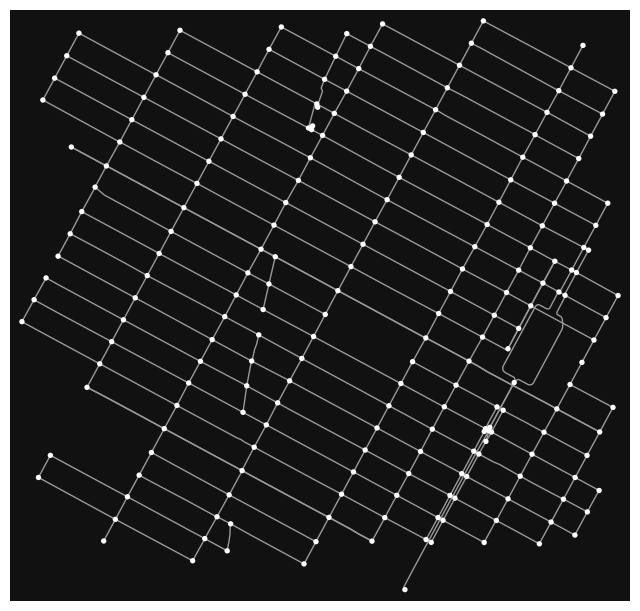

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
def convert_lane_to_numeric(lane):
    try:
        return int(lane)
    except ValueError:
        try:
            return float(lane)
        except ValueError:
            return None

# Helper function to calculate edge geometry if missing
def calculate_edge_geometry(u, v, graph):
    u_data = graph.nodes[u]
    v_data = graph.nodes[v]
    return LineString([(u_data['x'], u_data['y']), (v_data['x'], v_data['y'])])

G = ox.graph_from_polygon(polygon = osm_polygon, simplify= True, retain_all=True, truncate_by_edge=True, network_type = 'drive')
graph = ox.project_graph(G, to_crs=target_epsg)
ox.plot_graph(graph)

Now convert each line segment into road mesh using lanes as parameter to set road width

In [10]:
# Create a list to store GeoDataFrames for each road segment
gdf_roads_list = []
# Set the fixed Z coordinate for the buffer polygons
Z0 = .75  # You can adjust this value based on the desired elevation of the roads
# Create a list to store the meshes
mesh_list = []
mesh_collection = pv.PolyData()
# Iterate over each edge in the graph
for u, v, key, data in graph.edges(keys=True, data=True):
    # Check if the edge has geometry, otherwise create geometries from the nodes
    if 'geometry' not in data:
        data['geometry'] = calculate_edge_geometry(u, v, graph)

    # Get the lanes attribute for the edge
    lanes = data.get('lanes', 1)  # Default to 1 lane if lanes attribute is not available
    if not isinstance(lanes, list):
        lanes = [lanes]
        
    # Convert lane values to numeric (integers or floats) using the helper function
    num_lanes = [convert_lane_to_numeric(lane) for lane in lanes]

    # Filter out None values (representing non-numeric lanes) and calculate the road width
    num_lanes = [lane for lane in num_lanes if lane is not None]
    road_width = num_lanes[0] * 2.5
    # Buffer the LineString with the road width and add Z coordinate
    line_buffer = data['geometry'].buffer(road_width)

    clipped_shape = line_buffer.intersection(ground_polygon)
    if clipped_shape.is_empty:
        continue
    elif clipped_shape.geom_type == 'MultiPolygon':
        shapes_to_mesh = list(clipped_shape.geoms)
    else:
        shapes_to_mesh = [clipped_shape]

    for poly in shapes_to_mesh:
        exterior_coords = poly.exterior.coords
        z_coordinates = np.full(len(exterior_coords), Z0)
        
        oriented_coords = list(exterior_coords)
        # Ensure counterclockwise orientation (PyVista requirement for correct normals)
        if poly.exterior.is_ccw:
            oriented_coords.reverse()
            
        points = [(coord[0]-center_x, coord[1]-center_y) for coord in oriented_coords]
        
        # bounding polygon
        boundary_points_polydata = points_2d_to_poly(points, z_coordinates[0])
        mesh = boundary_points_polydata.delaunay_2d()
        
        # Add the mesh to the collection
        mesh_collection += mesh
        mesh_list.append(mesh)
        
output_file = f"../{LOCATION_DIR}/mesh/road_mesh_combined.ply"
pv.save_meshio(output_file,mesh_collection)
material_type = "mat-itu_concrete"
# Add shape elements for PLY files in the folder
sionna_shape = ET.SubElement(scene, "shape", type="ply", id=f"mesh-roads")
ET.SubElement(sionna_shape, "string", name="filename", value=f"../{LOCATION_DIR}/mesh/road_mesh_combined.ply")
bsdf_ref = ET.SubElement(sionna_shape, "ref", id= material_type, name="bsdf")
ET.SubElement(sionna_shape, "boolean", name="face_normals",value="true")

Warning: PLY doesn't support 64-bit integers. Casting down to 32-bit.

<Element 'boolean' at 0x779efb89d350>

##### Finally Save the scene file

In [11]:
# Create and write the XML file
tree = ET.ElementTree(scene)
xml_string = ET.tostring(scene, encoding="utf-8")
xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="    ")  # Adjust the indent as needed

with open(f"../{LOCATION_DIR}/simple_OSM_scene.xml", "w", encoding="utf-8") as xml_file:
    xml_file.write(xml_pretty)

In [12]:
import mitsuba as mi
mi.set_variant("llvm_ad_rgb")
from sionna.rt import load_scene, ITURadioMaterial

# 1. LOAD THE SCENE
scene_path = f"../{LOCATION_DIR}/simple_OSM_scene.xml"
sionna_scene = load_scene(scene_path)

# 2. CREATE MATERIALS WITH EXPLICIT THICKNESS
# We explicitly add 'thickness' to avoid the NoneType error.

# Create Brick Material (Red)
mat_brick = ITURadioMaterial(
    name="new_brick",
    itu_type="brick",
    color=(0.8, 0.2, 0.2),  # RGB Red
    thickness=0.3           # 30cm thickness
)

# Create Ground Material (Black/Dark Grey)
mat_ground = ITURadioMaterial(
    name="new_ground",
    itu_type="medium_dry_ground",
    color=(0.1, 0.1, 0.1),  # RGB Dark Grey
    thickness=1.0           # 1m thickness (arbitrary for ground)
)

# Create Concrete Material (Grey)
mat_concrete = ITURadioMaterial(
    name="new_concrete",
    itu_type="concrete",
    color=(0.5, 0.5, 0.5),  # RGB Grey
    thickness=0.2           # 20cm thickness
)

# 3. ADD MATERIALS TO SCENE
sionna_scene.add(mat_brick)
sionna_scene.add(mat_ground)
sionna_scene.add(mat_concrete)

# 4. ASSIGN MATERIALS TO OBJECTS
for name, obj in sionna_scene.objects.items():
    if "building" in name:
        obj.radio_material = "new_brick"
    elif "ground" in name:
        obj.radio_material = "new_ground"
    elif "road" in name:
        obj.radio_material = "new_concrete"

# 5. PREVIEW
sionna_scene.preview(resolution=(1200, 800))